<a href="https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/notebooks/2_ML_Refresher/house_price_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The first cell is included to automatically import the data from kaggle. But requires configuration, so you might prefer to skip it, and download the data manually.

In [4]:
import os

os.environ["KAGGLE_USERNAME"] = "rsancg00"
os.environ["KAGGLE_KEY"] = "KGAT_39b4b30d8723b7a880ab8d31c3f836f6"

!kaggle competitions download -c house-prices-advanced-regression-techniques
!unzip house-prices-advanced-regression-techniques.zip

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train_path = 'train.csv'
test_path = 'test.csv'
data_description_path = 'data_description.txt'
sample_submission_path = 'sample_submission.csv'

# Load the train dataset
data = pd.read_csv(train_path)

# Display the first few rows
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Missing values per column:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


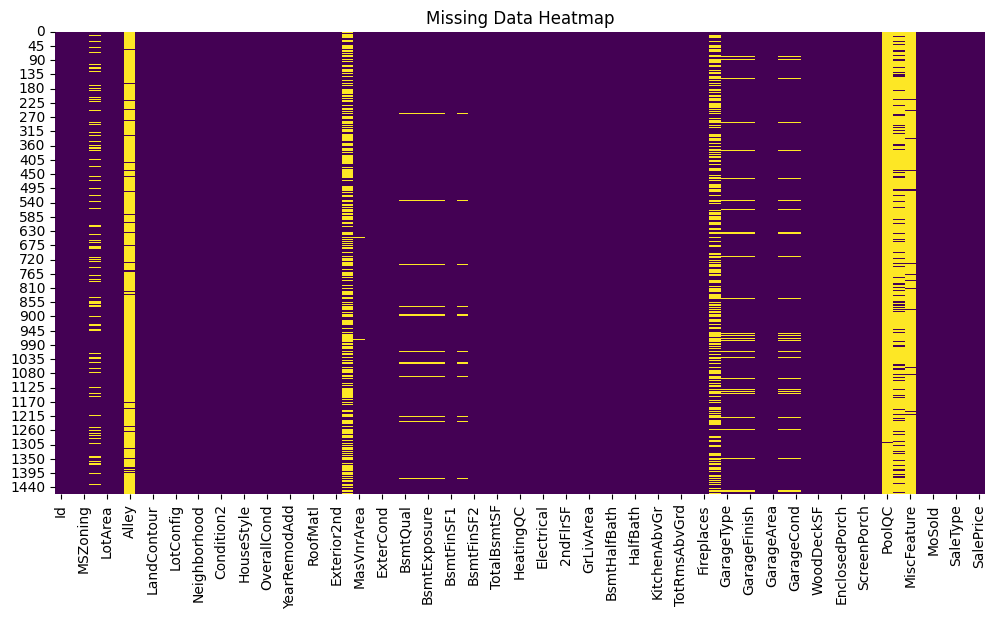

N elements  1460
                count unique     top  freq          mean           std  \
Id             1460.0    NaN     NaN   NaN         730.5    421.610009   
MSSubClass     1460.0    NaN     NaN   NaN      56.89726     42.300571   
MSZoning         1460      5      RL  1151           NaN           NaN   
LotFrontage    1201.0    NaN     NaN   NaN     70.049958     24.284752   
LotArea        1460.0    NaN     NaN   NaN  10516.828082   9981.264932   
...               ...    ...     ...   ...           ...           ...   
MoSold         1460.0    NaN     NaN   NaN      6.321918      2.703626   
YrSold         1460.0    NaN     NaN   NaN   2007.815753      1.328095   
SaleType         1460      9      WD  1267           NaN           NaN   
SaleCondition    1460      6  Normal  1198           NaN           NaN   
SalePrice      1460.0    NaN     NaN   NaN  180921.19589  79442.502883   

                   min       25%       50%       75%       max  
Id                 1.0    365

In [7]:
missing_values = data.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

print("N elements ", len(data))
# Display summary statistics
print(data.describe(include='all').T)
#Remove columns with more than 400 missing NaNs
good_colum_names = [data.columns[i] for i,count in enumerate(missing_values) if count<400]
data = data[good_colum_names]

In [8]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Separate numerical and categorical columns
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

# Impute missing values
data[num_cols] = num_imputer.fit_transform(data[num_cols])
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Verify no missing values remain
print("Remaining missing values per column:")
print(data.isnull().sum().sum())


Remaining missing values per column:
0


In [9]:
# Apply label encoding to categorical columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Display encoded data sample
data.head()

,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,3,3,0,4,0,5,2,2,0,...,0.0,2,2,2,0.0,2.0,2008.0,8,4,208500.0
1,0,3,3,0,2,0,24,1,2,0,...,0.0,2,2,2,0.0,5.0,2007.0,8,4,181500.0
2,0,0,3,0,4,0,5,2,2,0,...,0.0,2,2,2,0.0,9.0,2008.0,8,4,223500.0
3,0,0,3,0,0,0,6,2,2,0,...,0.0,2,2,2,0.0,2.0,2006.0,8,0,140000.0
4,0,0,3,0,2,0,15,2,2,0,...,0.0,2,2,2,0.0,12.0,2008.0,8,4,250000.0


In [10]:
target = 'SalePrice'
X = data.drop(columns=[target])
y = data[target]

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the split
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Training data shape: (1168, 74)
Validation data shape: (292, 74)


There is something important that I am not doing here. Feature scaling. I am not doing it because random forests can handle different scales for different features, but in things like a linear model or a deep learning model, feature scaling (aka, input normalization), is critical

Mean Squared Error Val: 832255256.8570155
R^2 Score val: 0.891496758498069
Mean Squared Error train: 122675220.44146977
R^2 Score train: 0.9794326122455872


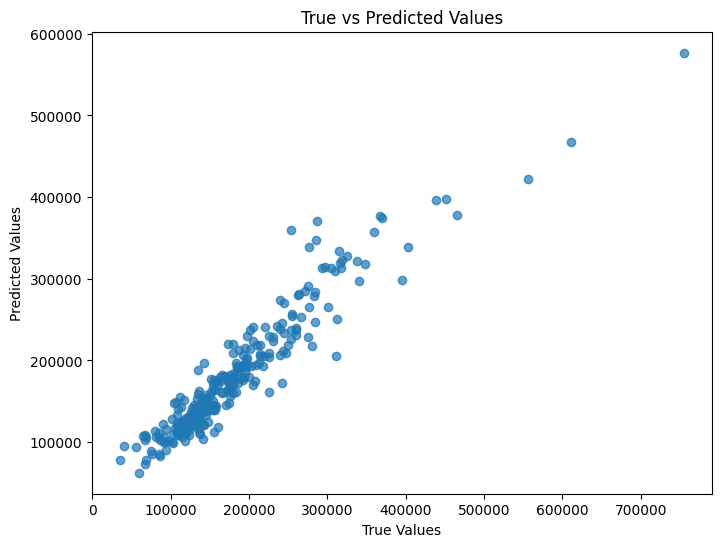

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model
rf.fit(X_train, y_train)

# Make validation predictions
y_pred_val = rf.predict(X_val)

# Evaluate performance
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f"Mean Squared Error Val: {mse_val}")
print(f"R^2 Score val: {r2_val}")


# Make validation predictions
y_pred_train = rf.predict(X_train)

# Evaluate performance
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"Mean Squared Error train: {mse_train}")
print(f"R^2 Score train: {r2_train}")


# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_val, alpha=0.7)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()


Feature Importances:
        Feature    Importance
11  OverallQual  5.565810e-01
40    GrLivArea  1.270769e-01
32  TotalBsmtSF  3.668365e-02
38     2ndFlrSF  3.542878e-02
28   BsmtFinSF1  3.120254e-02
..          ...           ...
69      MiscVal  7.560827e-05
58   GarageCond  7.278679e-05
0         Alley  3.329112e-05
68  MiscFeature  1.016531e-05
3     Utilities  1.043304e-07

[74 rows x 2 columns]


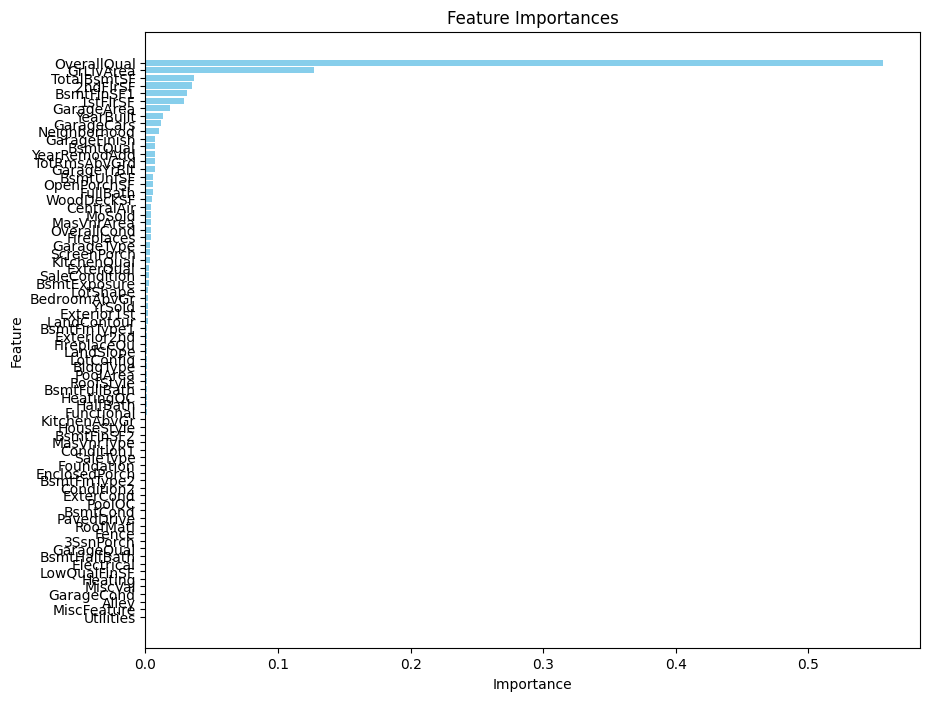

In [12]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [13]:
"""Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.
"""

def predict_test_set(model):
    test_data = pd.read_csv(test_path)
    ids = test_data["Id"]
    test_data[target] = 0 #Adding the target colum because the inputers where fitted with it
    test_data = test_data[good_colum_names] #good_colum_names used in the training process

    print(num_imputer.feature_names_in_)
    test_data[num_cols] = num_imputer.transform(test_data[num_cols])
    test_data[cat_cols] = cat_imputer.transform(test_data[cat_cols])
    for col in cat_cols:
        le = label_encoders[col]
        test_data[col] = le.transform(test_data[col])
    del test_data[target]

    # Make predictions on the test data
    test_predictions = model.predict(test_data)
    # Create a submission DataFrame
    submission_df = pd.DataFrame({'Id': ids.astype(np.int64), 'SalePrice': test_predictions})

    # Save the submission DataFrame to a csv file
    submission_df.to_csv('submission.csv', index=False)

    # Display the first few rows of the submission file
    print(submission_df.head().to_markdown(index=False, numalign="left", stralign="left"))

predict_test_set(rf)

['OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'MasVnrArea'
 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF'
 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces'
 'GarageYrBlt' 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF'
 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold'
 'YrSold' 'SalePrice']
| Id   | SalePrice   |
|:-----|:------------|
| 1461 | 127183      |
| 1462 | 153280      |
| 1463 | 175948      |
| 1464 | 186676      |
| 1465 | 206818      |


Since there is people that asked, I also added an example of anomaly/outliers detection using a non supervised method, the isolation forest. In many cases,it makes sense to remove outliers before training a supervised model. It is much better if the outlier removal method and the supervised method are based on different principles.

In [14]:
#Outlier detection with isolation forest

from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# Assuming X_train and y_train are your feature and target sets

# Combine X_train and y_train into a single DataFrame for easier processing
data = pd.concat([X_train, y_train], axis=1)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Set contamination to 5% for example

# Fit the model to the data (X_train + y_train)
iso_forest.fit(data)

# Get the predictions (-1 indicates outliers, 1 indicates inliers)
predictions = iso_forest.predict(data)

# Keep only the inliers (where prediction is 1)
inliers = predictions == 1

# Filter out the outliers from both X_train and y_train
X_train_filtered = X_train[inliers]
y_train_filtered = y_train[inliers]


In [15]:
#Outlier detection with kNN

from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Combine X_train and y_train into a single DataFrame for easier processing
data = pd.concat([X_train, y_train], axis=1)

# Initialize the kNN model (you can adjust the number of neighbors)
knn = NearestNeighbors(n_neighbors=5)  # Using 5 nearest neighbors, for example

# Fit the model to the data
knn.fit(data)

# Get the distances and indices of the nearest neighbors
distances, indices = knn.kneighbors(data)

# Calculate the mean distance to the nearest neighbors for each data point
mean_distances = np.mean(distances, axis=1)

# Set a threshold for the maximum acceptable distance to consider a point as an outlier
threshold = np.percentile(mean_distances, 95)  # For example, consider points in the top 5% of distances as outliers

# Identify outliers: if mean distance is greater than threshold, it's an outlier
outliers = mean_distances > threshold

# Filter out the outliers from both X_train and y_train
X_train_filtered = X_train[~outliers]
y_train_filtered = y_train[~outliers]
print(len(y_train_filtered), len(y_train))

1109 1168


You can now try if using X_train_filtered is a good idea or not

Mean Squared Error: 1740796443.760514
R^2 Score: 0.7730479256371938


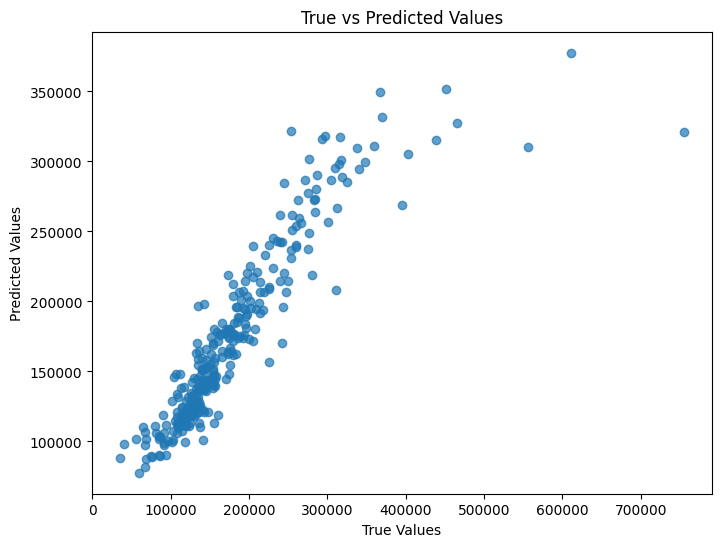

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model
rf.fit(X_train_filtered, y_train_filtered)

# Make predictions
y_pred = rf.predict(X_val)

# Evaluate performance
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.7)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()


This is an example of how to do automatic hyperparameter tuning

In [17]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 4.5 MB/s eta 0:00:00


In [18]:
import optuna
from sklearn.ensemble import RandomForestRegressor  # Use RandomForestClassifier if it's a classification problem
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression  # Use your own X_train and y_train here
from sklearn.metrics import mean_squared_error
import numpy as np


# Define the objective function for Optuna. This will contain the full training
# and scoring of the validation set process.
def objective(trial):
    # Hyperparameter search space
    param_grid = {
        'n_estimators': 200,  # Number of trees in the forest
        'max_depth': trial.suggest_int('max_depth', 2, 50),  # Maximum depth of trees
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),  # Minimum samples at a leaf node
        'max_features': trial.suggest_categorical('max_features', [1.0, 'sqrt', 'log2']),  # Maximum number of features to consider,
    }

    # Initialize the RandomForestRegressor with the suggested hyperparameters
    model = RandomForestRegressor(**param_grid, random_state=42)

    # Cross-validation score (using negative mean squared error as an example)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(score)
    # We return the negative mean of the cross-validation score as the objective to minimize
    return -score.mean()

# Create a study object to optimize the objective function
study = optuna.create_study(direction='minimize')  # Minimize negative mean squared error
study.optimize(objective, n_trials=100)  # You can adjust n_trials based on your computational budget

# Output the best hyperparameters found
print(f"Best hyperparameters: {study.best_params}")

# You can now use the best parameters to train your final model:
best_params = study.best_params
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_val)

# Evaluate performance
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



[I 2026-01-19 16:03:57,586] A new study created in memory with name: no-name-6313aa67-a8f8-49df-8781-5794d08e7bfd
[I 2026-01-19 16:04:04,494] Trial 0 finished with value: 1184688673.175988 and parameters: {'max_depth': 30, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 1184688673.175988.


[-1.35745256e+09 -1.01458500e+09 -1.82738385e+09 -9.61714123e+08
 -7.62307838e+08]


[I 2026-01-19 16:04:10,060] Trial 1 finished with value: 1139630176.3517556 and parameters: {'max_depth': 37, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 1139630176.3517556.


[-1.31950236e+09 -9.95139672e+08 -1.75699117e+09 -9.05208045e+08
 -7.21309640e+08]


[I 2026-01-19 16:04:15,805] Trial 2 finished with value: 1138194826.7802136 and parameters: {'max_depth': 48, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 1138194826.7802136.


[-1.26598679e+09 -1.01439667e+09 -1.76625973e+09 -9.15181306e+08
 -7.29149645e+08]


[I 2026-01-19 16:04:21,531] Trial 3 finished with value: 1090842746.7904696 and parameters: {'max_depth': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 3 with value: 1090842746.7904696.


[-1.19957451e+09 -1.02645570e+09 -1.67685857e+09 -8.59262254e+08
 -6.92062698e+08]


[I 2026-01-19 16:04:25,727] Trial 4 finished with value: 1091386237.289783 and parameters: {'max_depth': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 3 with value: 1090842746.7904696.


[-1.23601890e+09 -1.00901681e+09 -1.69454386e+09 -8.53296737e+08
 -6.64054885e+08]


[I 2026-01-19 16:04:32,765] Trial 5 finished with value: 1169004805.516457 and parameters: {'max_depth': 25, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 3 with value: 1090842746.7904696.


[-1.35759716e+09 -1.01507823e+09 -1.81456481e+09 -9.32857452e+08
 -7.24926373e+08]


[I 2026-01-19 16:04:39,580] Trial 6 finished with value: 1064455954.7236016 and parameters: {'max_depth': 26, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 6 with value: 1064455954.7236016.


[-1.16879891e+09 -9.94519289e+08 -1.66137266e+09 -8.32683528e+08
 -6.64905378e+08]


[I 2026-01-19 16:04:48,561] Trial 7 finished with value: 1254818813.6534827 and parameters: {'max_depth': 4, 'min_samples_leaf': 10, 'max_features': 1.0}. Best is trial 6 with value: 1064455954.7236016.


[-1.23088995e+09 -1.26685336e+09 -1.91000980e+09 -9.33398127e+08
 -9.32942832e+08]


[I 2026-01-19 16:04:50,992] Trial 8 finished with value: 1086321864.2773528 and parameters: {'max_depth': 32, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 6 with value: 1064455954.7236016.


[-1.22609341e+09 -1.01009488e+09 -1.68700119e+09 -8.50786327e+08
 -6.57633523e+08]


[I 2026-01-19 16:04:53,399] Trial 9 finished with value: 1086321864.2773528 and parameters: {'max_depth': 23, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 6 with value: 1064455954.7236016.


[-1.22609341e+09 -1.01009488e+09 -1.68700119e+09 -8.50786327e+08
 -6.57633523e+08]


[I 2026-01-19 16:05:32,471] Trial 10 finished with value: 925601963.8162171 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'max_features': 1.0}. Best is trial 10 with value: 925601963.8162171.


[-7.95433030e+08 -1.24293004e+09 -1.32453731e+09 -5.99040113e+08
 -6.66069323e+08]


[I 2026-01-19 16:06:08,474] Trial 11 finished with value: 925887805.6219107 and parameters: {'max_depth': 19, 'min_samples_leaf': 1, 'max_features': 1.0}. Best is trial 10 with value: 925601963.8162171.


[-8.07967119e+08 -1.24698810e+09 -1.31075797e+09 -6.00391817e+08
 -6.63334014e+08]


[W 2026-01-19 16:06:09,907] Trial 12 failed with parameters: {'max_depth': 14, 'min_samples_leaf': 1, 'max_features': 1.0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-3702619787.py", line 24, in objective
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 684, in cross_val_score
    cv_results = cross_validate(
                 ^^^^^^^^^^^^^^^
  File "/usr/l

KeyboardInterrupt: 